# Predicting student learning performance in a Virtual Learning Environment using activity data

In [3]:
from ibmdbpy import IdaDataBase, IdaDataFrame
import seaborn as sns
import pandas as pd
import numpy as np

## A cleaner way to import the data while preserving table names

In [4]:
schema_name = 'LSR68256'
table_names = ['STUDENT_INFO', 'ASSESSMENTS','COURSES','VLE','STUDENT_ASSESSMENT','STUDENT_REGISTRATION','STUDENT_VLE2']

In [5]:
idadb_c667f3e30cc04bae88b4ad591071d6b2 = IdaDataBase(dsn='DASHDB;Database=BLUDB;Hostname=dashdb-txn-sbox-yp-lon02-02.services.eu-gb.bluemix.net;Port=50000;PROTOCOL=TCPIP;UID=lsr68256;PWD=2cz+b3kf2t4tsbl1')
lop_tables = dict()
for table_name in table_names:
    data_df = IdaDataFrame(idadb_c667f3e30cc04bae88b4ad591071d6b2, str.format('{0}.{1}',schema_name,table_name)).as_dataframe()    
    df = pd.DataFrame(data = data_df)
    lop_tables[table_name] = df

In [6]:
idadb_c667f3e30cc04bae88b4ad591071d6b2.close()

Connection closed.


In [5]:
lop_tables['STUDENT_INFO'].describe()

,id_student,num_of_prev_attempts,studied_credits
count,3.259300e+04,32593.000000,32593.000000
mean,7.066877e+05,0.163225,79.758691
std,5.491673e+05,0.479758,41.071900
min,3.733000e+03,0.000000,30.000000
25%,5.085730e+05,0.000000,60.000000
50%,5.903100e+05,0.000000,60.000000
75%,6.444530e+05,0.000000,120.000000
max,2.716795e+06,6.000000,655.000000


In [7]:
lop_tables['STUDENT_INFO'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
code_module             32593 non-null object
code_presentation       32593 non-null object
id_student              32593 non-null int64
gender                  32593 non-null object
region                  32593 non-null object
highest_education       32593 non-null object
imd_band                32593 non-null object
age_band                32593 non-null object
num_of_prev_attempts    32593 non-null int64
studied_credits         32593 non-null int64
disability              32593 non-null object
final_result            32593 non-null object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB


In [8]:
lop_tables['STUDENT_INFO']['final_result'].describe()

count     32593
unique        4
top        Pass
freq      12361
Name: final_result, dtype: object

In [8]:
lop_tables['STUDENT_INFO']['final_result'].value_counts()

Pass           12361
Withdrawn      10156
Fail            7052
Distinction     3024
Name: final_result, dtype: int64

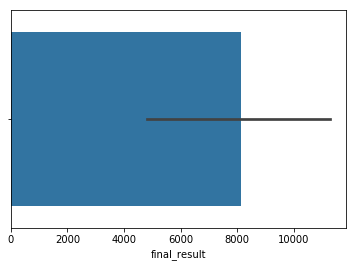

In [9]:
sns.barplot(lop_tables['STUDENT_INFO']['final_result'].value_counts())

In [10]:
lop_tables['STUDENT_INFO'].head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


## Can we use VLE activities to predict a student's final result?

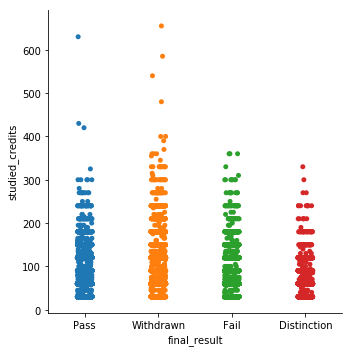

In [11]:
sns.catplot(x = "final_result", y = "studied_credits", data = lop_tables['STUDENT_INFO'])

In [12]:
lop_tables['STUDENT_ASSESSMENT'].head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78
1,1752,28400,22,0,70
2,1752,31604,17,0,72
3,1752,32885,26,0,69
4,1752,38053,19,0,79


In [12]:
lop_tables['STUDENT_ASSESSMENT']['score'].describe()

count     173912
unique       102
top          100
freq       18813
Name: score, dtype: object

In [13]:
lop_tables['STUDENT_INFO'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
code_module             32593 non-null object
code_presentation       32593 non-null object
id_student              32593 non-null int64
gender                  32593 non-null object
region                  32593 non-null object
highest_education       32593 non-null object
imd_band                32593 non-null object
age_band                32593 non-null object
num_of_prev_attempts    32593 non-null int64
studied_credits         32593 non-null int64
disability              32593 non-null object
final_result            32593 non-null object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB


In [14]:
lop_tables['STUDENT_VLE2'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065858 entries, 0 to 1065857
Data columns (total 7 columns):
Column_0             1065858 non-null int64
code_module          1065858 non-null object
code_presentation    1065858 non-null object
id_student           1065858 non-null int64
id_site              1065858 non-null int64
date                 1065858 non-null int64
sum_click            1065858 non-null int64
dtypes: int64(5), object(2)
memory usage: 56.9+ MB


## Joining the datasets to merge related data

We use the pandas merge function to join the data from the required dataframes to form one large supertable.

In [26]:
student_full_vle = pd.merge(lop_tables['STUDENT_INFO'], lop_tables['STUDENT_VLE2'], on='id_student', how='inner')

In [27]:
student_full_vle_details = pd.merge(student_full_vle, lop_tables['VLE'], on = 'id_site', how = 'inner')

In [28]:
student_full_vle.tail()

,code_module_x,code_presentation_x,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,Column_0,code_module_y,code_presentation_y,id_site,date,sum_click
1301169,GGG,2014J,2684003,F,Yorkshire Region,HE Qualification,50-60%,35-55,0,30,N,Distinction,1061032,GGG,2014J,897064,143,1
1301170,GGG,2014J,2684003,F,Yorkshire Region,HE Qualification,50-60%,35-55,0,30,N,Distinction,1061326,GGG,2014J,896943,149,6
1301171,GGG,2014J,2684003,F,Yorkshire Region,HE Qualification,50-60%,35-55,0,30,N,Distinction,1061729,GGG,2014J,896978,156,3
1301172,GGG,2014J,2684003,F,Yorkshire Region,HE Qualification,50-60%,35-55,0,30,N,Distinction,1062465,GGG,2014J,896984,171,4
1301173,GGG,2014J,2684003,F,Yorkshire Region,HE Qualification,50-60%,35-55,0,30,N,Distinction,1064869,GGG,2014J,896943,219,1


In [16]:
lop_tables['VLE'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 6 columns):
id_site              6364 non-null int64
code_module          6364 non-null object
code_presentation    6364 non-null object
activity_type        6364 non-null object
week_from            6364 non-null object
week_to              6364 non-null object
dtypes: int64(1), object(5)
memory usage: 298.4+ KB


In [29]:
student_full_vle_details.head()

,code_module_x,code_presentation_x,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,code_module_y,code_presentation_y,id_site,date,sum_click,code_module,code_presentation,activity_type,week_from,week_to
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,...,AAA,2013J,546900,1,1,AAA,2013J,url,,
1,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,...,AAA,2013J,546900,20,1,AAA,2013J,url,,
2,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,...,AAA,2013J,546900,23,1,AAA,2013J,url,,
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,...,AAA,2013J,546900,124,1,AAA,2013J,url,,
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,...,AAA,2013J,546900,106,2,AAA,2013J,url,,


Group by id_student and code_module_x + code_presentation_x

In [30]:
student_full_vle_details.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1301174 entries, 0 to 1301173
Data columns (total 23 columns):
code_module_x           1301174 non-null object
code_presentation_x     1301174 non-null object
id_student              1301174 non-null int64
gender                  1301174 non-null object
region                  1301174 non-null object
highest_education       1301174 non-null object
imd_band                1301174 non-null object
age_band                1301174 non-null object
num_of_prev_attempts    1301174 non-null int64
studied_credits         1301174 non-null int64
disability              1301174 non-null object
final_result            1301174 non-null object
Column_0                1301174 non-null int64
code_module_y           1301174 non-null object
code_presentation_y     1301174 non-null object
id_site                 1301174 non-null int64
date                    1301174 non-null int64
sum_click               1301174 non-null int64
code_module             130117

In [19]:
student_full_vle_details['final_result'] = student_full_vle_details.final_result.astype(str)

In [20]:
student_full_vle_details.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1301174 entries, 0 to 1301173
Data columns (total 23 columns):
code_module_x           1301174 non-null object
code_presentation_x     1301174 non-null object
id_student              1301174 non-null int64
gender                  1301174 non-null object
region                  1301174 non-null object
highest_education       1301174 non-null object
imd_band                1301174 non-null object
age_band                1301174 non-null object
num_of_prev_attempts    1301174 non-null int64
studied_credits         1301174 non-null int64
disability              1301174 non-null object
final_result            1301174 non-null object
Column_0                1301174 non-null int64
code_module_y           1301174 non-null object
code_presentation_y     1301174 non-null object
id_site                 1301174 non-null int64
date                    1301174 non-null int64
sum_click               1301174 non-null int64
code_module             130117

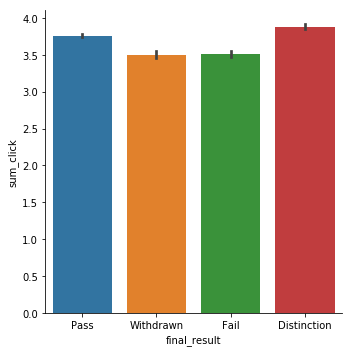

In [33]:
sns.catplot(x = 'final_result', y = 'sum_click', data = student_full_vle_details, kind='bar')

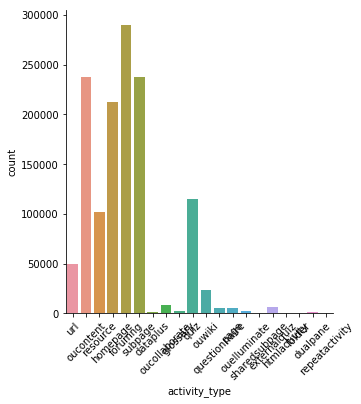

In [36]:
plt = sns.catplot(x = 'activity_type', kind = 'count', data = student_full_vle_details)
plt.set_xticklabels(rotation = 45)

An inspection of the midsection of the dataset

In [37]:
# sns.distplot(student_full_vle_details.activity_type)
student_full_vle_details[500000:500005]

,code_module_x,code_presentation_x,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,code_module_y,code_presentation_y,id_site,date,sum_click,code_module,code_presentation,activity_type,week_from,week_to
500000,CCC,2014B,614265,M,South Region,Lower Than A Level,50-60%,35-55,0,120,...,CCC,2014J,909013,96,1,CCC,2014J,homepage,,
500001,CCC,2014B,614265,M,South Region,Lower Than A Level,50-60%,35-55,0,120,...,CCC,2014J,909013,234,2,CCC,2014J,homepage,,
500002,CCC,2014J,614265,M,South Region,Lower Than A Level,50-60%,35-55,1,60,...,CCC,2014J,909013,1,9,CCC,2014J,homepage,,
500003,CCC,2014J,614265,M,South Region,Lower Than A Level,50-60%,35-55,1,60,...,CCC,2014J,909013,9,2,CCC,2014J,homepage,,
500004,CCC,2014J,614265,M,South Region,Lower Than A Level,50-60%,35-55,1,60,...,CCC,2014J,909013,72,1,CCC,2014J,homepage,,


Checking for null data in each column

In [38]:
student_full_vle_details.apply(lambda x: sum(x.isnull()), axis=0)

code_module_x           0
code_presentation_x     0
id_student              0
gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
final_result            0
Column_0                0
code_module_y           0
code_presentation_y     0
id_site                 0
date                    0
sum_click               0
code_module             0
code_presentation       0
activity_type           0
week_from               0
week_to                 0
dtype: int64

Looks good. Time to encode the categorical data columns:

In [39]:
from sklearn.preprocessing import LabelEncoder



In [40]:
cat_feature_names = ['gender', 'region', 'activity_type', 'disability', 'age_band', 'imd_band', 'highest_education', 'code_module', 'code_presentation']
le = LabelEncoder()
for f in cat_feature_names:
    student_full_vle_details[f] = le.fit_transform(student_full_vle_details[f])
student_full_vle_details.dtypes

code_module_x           object
code_presentation_x     object
id_student               int64
gender                   int64
region                   int64
highest_education        int64
imd_band                 int64
age_band                 int64
num_of_prev_attempts     int64
studied_credits          int64
disability               int64
final_result            object
Column_0                 int64
code_module_y           object
code_presentation_y     object
id_site                  int64
date                     int64
sum_click                int64
code_module              int64
code_presentation        int64
activity_type            int64
week_from               object
week_to                 object
dtype: object

In [41]:
import numpy as np

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

def classification_model(model, data, predictors, outcome):
    model.fit(data[predictors], data[outcome])
    predictions = model.predict(data[predictors])
    
    accuracy = metrics.accuracy_score(predictions, data[outcome])
    print("Accuracy : %s" % "{0:.3%}".format(accuracy))
    # kf = KFold(data.shape[0],n_splits = 5)    
    kf = KFold(n_splits = 5)
    error = []
    for train, test in kf.split(data):
        train_predictors = (data[predictors].iloc[train, :])
        train_target = data[outcome].iloc[train]
        model.fit(train_predictors, train_target)
        error.append(model.score(data[predictors].iloc[test, :], data[outcome].iloc[test]))
        
    print("Cross validation score : %s" % "{0:.3%}".format(np.mean(error)))
    model.fit(data[predictors], data[outcome])

In [43]:
outcome_var = 'final_result'
model = LogisticRegression()
predictor_var = ['id_site','sum_click','activity_type','studied_credits','highest_education']
classification_model(model, student_full_vle_details, predictor_var, outcome_var)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy : 55.111%


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linea

Cross validation score : 55.111%


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [54]:
model = DecisionTreeClassifier()
classification_model(model, student_full_vle_details, predictor_var, outcome_var)

Accuracy : 62.913%
Cross validation score : 47.154%


In [55]:
model = RandomForestClassifier(n_estimators=100)
predictor_var = ['imd_band', 'age_band', 'num_of_prev_attempts','studied_credits','code_module','code_presentation','activity_type','sum_click','id_site']
classification_model(model, student_full_vle_details, predictor_var, outcome_var)


Accuracy : 74.874%
Cross validation score : 55.259%


In [56]:
model = RandomForestClassifier(n_estimators=30, max_depth=5)
classification_model(model, student_full_vle_details, predictor_var, outcome_var)

Accuracy : 55.157%
Cross validation score : 55.133%
